**Table of contents**<a id='toc0_'></a>    
- [Mise en place](#toc1_)    
  - [Chargement des données](#toc1_1_)    
  - [Préparation des données](#toc1_2_)    
  - [Vectorisation](#toc1_3_)    
  - [LDA](#toc1_4_)    
- [Classification OneVsRest](#toc2_)    
- [Régression logistique](#toc3_)    
  - [Nombre de tags prédits](#toc3_1_)    
- [🦄🦄 CHECKPOINT 🦄🦄](#toc4_)    
- [Approche sentence embedding](#toc5_)    
- [Word 2 Vec](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=2
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Mise en place](#toc0_)

In [1]:
# OS & env
import os
import logging
import time

# DS
import numpy as np
import pandas as pd
import dill as pickle

# ML
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import FunctionTransformer
# from sklearn.feature_extraction.text import TfidfVectorizer

# home made functions from the src folder
from src.scrap_and_clean import init_data
from src.models import results_from_vec_matrix
from src.models import get_5_tags_from_matrix
from src.models import score_reduce
from src.models import plot_model
from src.models import eval_lda_n_topics
from src.models import get_topics
from src.models import lr_predict_tags
from src.models import score_plot_model

# logging configuration (see all outputs, even DEBUG or INFO)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

## <a id='toc1_1_'></a>[Chargement des données](#toc0_)

In [2]:
df_pp = init_data()

INFO:root:✅ Preprocessed data loaded


In [3]:
print(f"DF shape: {df_pp.shape}")
display(df_pp.head())

DF shape: (49975, 10)


,doc_bow,tags,score,answers,views,date,title_bow,title,body_bow,body
0,itms-91053 missing api declaration privacy sud...,ios app-store plist,24,7,3092,2024-03-14 22:55:18,itms-91053 missing api declaration privacy,ITMS-91053: Missing API declaration - Privacy,suddent successful build apple,<p>Why am I all of a suddent getting this on s...
1,builtin sorted slower list containing descendi...,python algorithm performance sorting time-comp...,28,2,2699,2024-03-05 15:21:50,builtin sorted slower list containing descendi...,Why is builtin sorted() slower for a list cont...,sorted four similar list list consistently tak...,<p>I sorted four similar lists. List <code>d</...
2,std :shared_mutex :unlock_shared block though ...,c++ windows multithreading stl,26,5,1388,2024-03-01 23:09:59,std :shared_mutex :unlock_shared block though ...,std::shared_mutex::unlock_shared() blocks even...,team encountered deadlock suspect bug windows ...,<p>My team has encountered a deadlock that I s...
3,rules nullptr init unique_ptr c++ compiles msv...,c++ visual-c++ language-lawyer unique-ptr c++23,15,1,490,2024-02-22 11:29:42,rules nullptr init unique_ptr c++,Did the rules for nullptr init of unique_ptr c...,compiles msvc c++ mode failes c++ mode current...,<p>This code compiles with MSVC from VS 2022 i...
4,order elf relocation applied specified conside...,c++ elf dynamic-linking abi,16,1,1746,2024-02-19 21:42:03,order elf relocation applied specified,Where is the order in which ELF relocations ar...,consider linux system use_message.cpp libmessa...,<p>Consider the following two files on a Linux...


## <a id='toc1_2_'></a>[Préparation des données](#toc0_)

Pour **alléger les temps de calcul** suivants **tout en gardant un jeu de données suffisant**, seules les **données des 5 dernières années** sont gardées (20% du jeu de données initial)

In [4]:
df_recent = df_pp.loc[df_pp['date'] >= '2019-05-01']

Sélection des données indispensables seulement

In [5]:
df = df_recent[["doc_bow", "tags"]]
print(f"DF shape: {df.shape}")

DF shape: (9999, 2)


Séparation de 1000 documents pour les tests, le reste pour l'entraînement des modèles.

In [6]:
random_state = 42
test_size = 1000

# X, y, train, test split
X_train, X_test, y_train, y_test = train_test_split(
    df["doc_bow"], df["tags"], test_size=test_size, random_state=random_state
)

## <a id='toc1_3_'></a>[Vectorisation](#toc0_)

Comptage des termes >= 100 occurrences dans le corpus

In [7]:
count_vectorizer = CountVectorizer(token_pattern=r"\S+", dtype=np.uint16, min_df=100)

X_train_cv = count_vectorizer.fit_transform(X_train)
X_test_cv = count_vectorizer.transform(X_test)
cv_names = count_vectorizer.get_feature_names_out()

In [8]:
cv_dict = dict(zip(cv_names, X_test_cv.sum(axis=0).A1.astype(np.uint16)))
cv_dict_sorted = {
    k: v for k, v in sorted(cv_dict.items(), key=lambda item: item[1], reverse=True)
}

print(f"{len(cv_dict)} terms in CV")

741 terms in CV


## <a id='toc1_4_'></a>[LDA](#toc0_)

(dans le seul but de visualiser les données par groupes)

Détermination du nombre de sujets

Evaluating n=5...
	500.8290167126467
Evaluating n=7...
	488.9392398712481
Evaluating n=10...
	482.7922309558595
Evaluating n=20...
	484.45614870209266
Evaluating n=30...


DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/vscode/.env/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/vscode/.env/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/vscode/.env/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/

	494.31376389217957


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/vscode/.env/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.

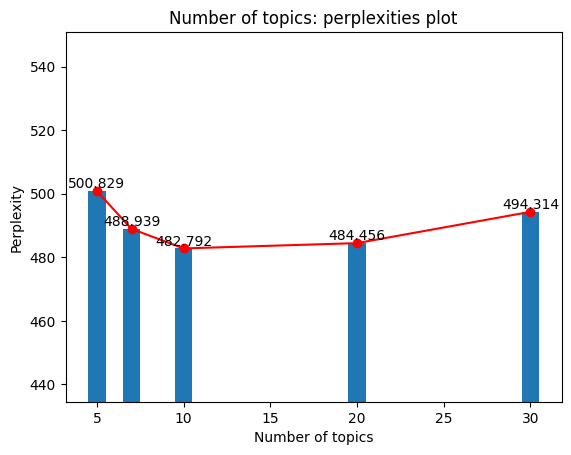

In [9]:
perplexities = eval_lda_n_topics(random_state, X_train_cv, n_list=[5, 7, 10, 20, 30], width=1)

LDA sur les données

In [10]:
n_topics = 10
lda = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=random_state,
)

# topics for train data
lda.fit(X_train_cv)
n_top_words = 10
topics = get_topics(lda, cv_names, n_top_words)

# topics for test data
X_test_lda = lda.transform(X_test_cv)
top_topics_test = [xi.argsort()[:-2: -1][0] for xi in X_test_lda]

# <a id='toc2_'></a>[Classification OneVsRest](#toc0_)

#### 🚧 Expliquer [modèle](https://machinelearningmastery.com/one-vs-rest-and-one-vs-one-for-multi-class-classification/)

# <a id='toc3_'></a>[Régression logistique](#toc0_)

#### 🚧 Expliquer modèle + dire appoche classique (pas de sentence embedding)

In [11]:
%%time
logreg = LogisticRegression(multi_class='ovr')
logreg.fit(X_train_cv, y_train)

CPU times: user 3min 36s, sys: 647 ms, total: 3min 37s
Wall time: 3min 55s


LogisticRegression(multi_class='ovr')

In [12]:
lr_preds_raw = logreg.predict(X_test_cv)

Exemple

In [13]:
i = 4

print(f"data:\n\t{X_test.tolist()[i]}")
print(f"topic {top_topics_test[i]}:\n\t{topics[top_topics_test[i]]}")
print(f"pred:\n\t{lr_preds_raw[i]}")
print(f"target:\n\t{y_test.tolist()[i]}")

data:
	cross-site cookies set cookie backend frontend currently developing webapp frontend backend test jointly chrome frontend make correct api call backend display cookies apology advance long post going many resources past couple day point unsure relevant frontend backend proper settings cors believe backend situation frontend make request backend backend set cookie attempt set cookie backend make request frontend attempt tab chrome get warning network tab get message examining response header research come attempt set cookie backend make request frontend attempt tab chrome get exact warning attempt though response header additionally header warning try come attempt everything attempt except fetch get warning backend missing attempt surely must easy set cookie backend frontend worrying https choice locally backend server accessed research made seem complicated/time-consuming process fair understanding web-dev/all thing network limited
topic 8:
	api request get call spring message br

## <a id='toc3_1_'></a>[Nombre de tags prédits](#toc0_)

Il est possible que certaines prédictions soient nulles ou bien qu'elles ne renvoient pas les 5 tags souhaités

In [14]:
print(f"5 tags: {len([p for p in lr_preds_raw if len(p.split(' ')) == 5])}")
print(f"4 tags: {len([p for p in lr_preds_raw if len(p.split(' ')) == 4])}")
print(f"3 tags: {len([p for p in lr_preds_raw if len(p.split(' ')) == 3])}")
print(f"2 tags: {len([p for p in lr_preds_raw if len(p.split(' ')) == 2])}")
print(f"1 only tag: {len([p for p in lr_preds_raw if len(p.split(' ')) == 1])}")
print(f"No tag: {len([p for p in lr_preds_raw if len(p.split(' ')) < 1])}")

5 tags: 512
4 tags: 317
3 tags: 111
2 tags: 53
1 only tag: 7
No tag: 0


Il est possible d'utiliser les prédictions pour obtenir directement les 5 tags souhaités

In [15]:
def lr_predict_tags(model, X, n_tags=5) -> list:
    """Use logistic regression probabilities to get at least n predicted tags"""
    ppbs = model.predict_proba(X)
    classes = model.classes_
    pred_tags = []

    for i, x in enumerate(X):
        # create list of tags from n first classes
        pred_list = (" ").join([classes[c] for c in ppbs[i].argsort()[: -n_tags - 1 : -1]]).split(" ")
        # keep only 5 first tags
        pred = set()
        j = 0
        while len(pred) < 5:
            pred.add(pred_list[j])
            j += 1
        # add tags to predictions list
        pred_tags.append((" ").join(pred))

    return pred_tags

Application sur les données de test

In [16]:
lr_preds = lr_predict_tags(logreg, X_test_cv)

Exemple

In [17]:
print(f"data:\n\t{X_test.tolist()[i]}")
print(f"topic {top_topics_test[i]}:\n\t{topics[top_topics_test[i]]}")
print(f"raw predictions:\n\t{lr_preds_raw[i]}")
print(f"target:\n\t{y_test.tolist()[i]}")
print(f"5 tags predictions:\n\t{lr_preds[i]}")

data:
	cross-site cookies set cookie backend frontend currently developing webapp frontend backend test jointly chrome frontend make correct api call backend display cookies apology advance long post going many resources past couple day point unsure relevant frontend backend proper settings cors believe backend situation frontend make request backend backend set cookie attempt set cookie backend make request frontend attempt tab chrome get warning network tab get message examining response header research come attempt set cookie backend make request frontend attempt tab chrome get exact warning attempt though response header additionally header warning try come attempt everything attempt except fetch get warning backend missing attempt surely must easy set cookie backend frontend worrying https choice locally backend server accessed research made seem complicated/time-consuming process fair understanding web-dev/all thing network limited
topic 8:
	api request get call spring message br

Résultats sur l'échantillon de test : prédictions basiques

Score:  0.227 - Duration:  21.0


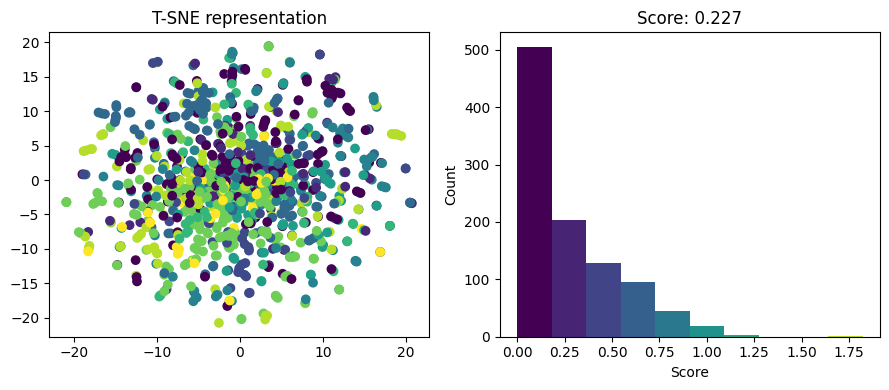

In [19]:
lr_scores_raw = score_plot_model(lr_preds_raw, logreg.predict_proba(X_test_cv), y_test, top_topics=top_topics_test)

Résultats sur l'échantillon de test : prédictions à 5 tags

Score:  0.258 - Duration:  21.0


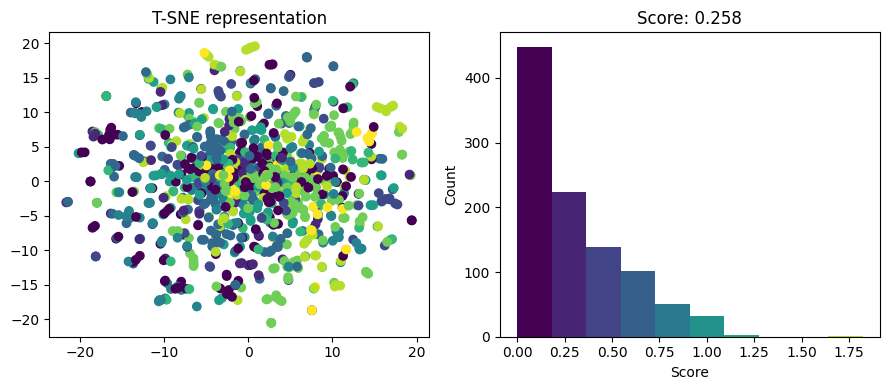

In [21]:
lr_scores = score_plot_model(lr_preds, logreg.predict_proba(X_test_cv), y_test, top_topics=top_topics_test)

Les scores sont mécaniquement améliorés avec la prédiction systématique des 5 tags.

On constate aussi que dans de rares cas, certains scores sont supérieurs à 1.  
Cela se produit seulement lorsqu'il y a peu de tags et que ceux-ci sont trouvés plusieurs fois par les prédictions.

In [23]:
i = 75

print(f"data:\n\t{X_test.tolist()[i]}")
print(f"topic {top_topics_test[i]}:\n\t{topics[top_topics_test[i]]}")
print(f"pred:\n\t{lr_preds[i]}")
print(f"target:\n\t{y_test.tolist()[i]}")
print(f"score:\n\t{lr_scores[1][i]}")

data:
	angular this.formgroup.updatevalueandvalidity properly add remove validators controls based certain condition updating validators whole form updating specifically applying control i.e write control hope correct wrong
topic 3:
	test function component class c++ compiler object case call return
pred:
	angular9 angular8 npm angular-cli angular
target:
	angular typescript
score:
	1.822


# <a id='toc4_'></a>[🦄🦄 CHECKPOINT 🦄🦄](#toc0_)

#### 🚧 ajouter [jaccard score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html) au score_model

# <a id='toc5_'></a>[Approche sentence embedding](#toc0_)

# <a id='toc6_'></a>[Word 2 Vec](#toc0_)

#### 🚧 Expliquer modèle